In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.1.0


In [2]:
# https://stackoverflow.com/questions/57469676/python-one-hot-encoding-for-comma-separated-values
def one_hot_encode(df):
    dummies = df['subjects'].str.get_dummies(sep=",")
    df_copy = pd.concat([df.drop('subjects', 1), dummies], 1)
    return (df_copy, dummies.columns)

In [3]:
train = pd.read_csv('train.tsv', delimiter='\t', header=None)
val = pd.read_csv('valid.tsv', delimiter='\t', header=None)
test = pd.read_csv('test.tsv', delimiter='\t', header=None)
rename_columns = ['ID', 'label', 'statement', 'subjects', 'speaker', 'speaker_job_title', 'state_info',
                  'party_affiliation', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire',
                  'context'
                 ]
train.columns = rename_columns
val.columns = rename_columns
test.columns = rename_columns
all_data = pd.concat([train, val, test])

# X_train, y_train = train.drop(drop_columns, axis=1), train['label']
# X_val, y_val = val.drop(drop_columns, axis=1), val['label']
# X_test, y_test = test.drop(drop_columns, axis=1), test['label']

In [4]:
train.head()

,ID,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [5]:
# deal with NaNs
print('Train', train.isna().sum().to_dict())
print('Train length: ', len(train))
print('Val: ', val.isna().sum().to_dict())
print('Val length: ', len(val))
print('Test: ', test.isna().sum().to_dict())
print('Test length: ', len(test))

Train {'ID': 0, 'label': 0, 'statement': 0, 'subjects': 2, 'speaker': 2, 'speaker_job_title': 2897, 'state_info': 2208, 'party_affiliation': 2, 'barely_true': 2, 'false': 2, 'half_true': 2, 'mostly_true': 2, 'pants_on_fire': 2, 'context': 102}
Train length:  10240
Val:  {'ID': 0, 'label': 0, 'statement': 0, 'subjects': 0, 'speaker': 0, 'speaker_job_title': 345, 'state_info': 279, 'party_affiliation': 0, 'barely_true': 0, 'false': 0, 'half_true': 0, 'mostly_true': 0, 'pants_on_fire': 0, 'context': 12}
Val length:  1284
Test:  {'ID': 0, 'label': 0, 'statement': 0, 'subjects': 0, 'speaker': 0, 'speaker_job_title': 325, 'state_info': 262, 'party_affiliation': 0, 'barely_true': 0, 'false': 0, 'half_true': 0, 'mostly_true': 0, 'pants_on_fire': 0, 'context': 17}
Test length:  1267


<BarContainer object of 14 artists>

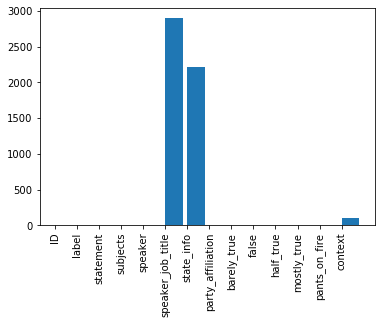

In [6]:
train_NaN = train.isna().sum().to_dict()
plt.xticks(rotation=90)
plt.bar(train_NaN.keys(), train_NaN.values(), align='edge')

In [7]:
'''
General:
ID: is extraneous information
speaker truth value counts: data leakage? this seems to include possible future information in the dataset?

NaNs:
drop speaker_job_title and state_info because just way too many NaNs to be able to fill them well with dummy values
context doesn't have too many but not sure I could use it. Since they are sentence, I think an empty string could be interpretd as no information
all other NaN were dropped by row
'''
# drop_columns = ['ID', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'speaker_job_title',
#                'state_info']
drop_columns = ['ID']
train.drop(drop_columns, axis=1, inplace = True)
train['context'].fillna('', inplace = True)
train.dropna(axis=0, how='all', subset=['subjects'], inplace=True)
train.dropna(axis=0, how='all', subset=['speaker'], inplace=True)
train.dropna(axis=0, how='all', subset=['party_affiliation'], inplace=True)

val.drop(drop_columns, axis=1, inplace = True)
val['context'].fillna('', inplace = True)
val.dropna(axis=0, how='all', subset=['subjects'], inplace=True)
val.dropna(axis=0, how='all', subset=['speaker'], inplace=True)
val.dropna(axis=0, how='all', subset=['party_affiliation'], inplace=True)

test.drop(drop_columns, axis=1, inplace = True)
test['context'].fillna('', inplace = True)
test.dropna(axis=0, how='all', subset=['subjects'], inplace=True)
test.dropna(axis=0, how='all', subset=['speaker'], inplace=True)
test.dropna(axis=0, how='all', subset=['party_affiliation'], inplace=True)

10238
half-true      2114
false          1993
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: label, dtype: int64


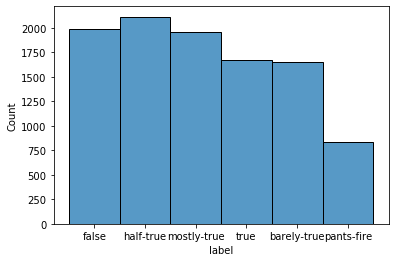

In [8]:
# histogram of labels to check for class imbalance
print(len(train['label']))
sns.histplot(data=train['label'])
print(train['label'].value_counts())

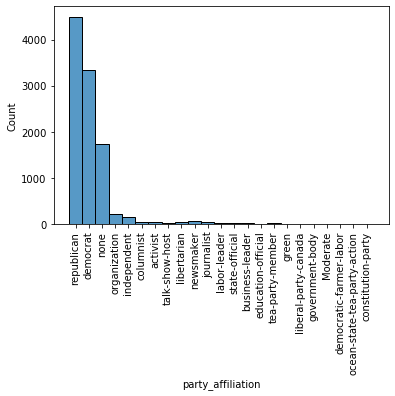

In [9]:
# histogram of party affiliation
'''
this could be an issue, some of these groups like tea_party_member are part of the Republican Party 
but that isn't considered here. How would model understand that a tea_party_member might share some 
ideas with Republican Party. Will be worth to see how well these points end up getting classified if
party_affiliation becomes an important feature
'''
g = sns.histplot(data=train['party_affiliation'])
g.set_xticklabels(labels=train['party_affiliation'].unique() ,rotation=90)
print()

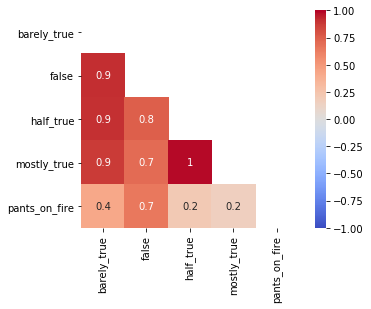

In [10]:
# correlation matrix - not that useful because it only works with numerical features
sns.heatmap(train.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, 
            center= 0, cmap= 'coolwarm', square=True, mask=np.triu(train.corr()))

In [11]:
# one hot encode
train, subject_cols = one_hot_encode(train)

In [12]:
# check relationships between subjects and labels
print(subject_cols)
subject_dict = {}
label_types = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
for lt in label_types:
    for s in subject_cols:
#         temp = train.apply(lambda x : True 
#                             if x[s] == 1 and x['label'] == lt else False, axis = 1)
#         count = len(temp[temp == True].index)
#         print(count)
        count = train[(train[s] == 1) & (train['label'] == lt)].count()[0] # label is at 0th index
#         print(count)
#         print('s: {} lt: {}'.format(s, lt))
        if s in subject_dict:
            subject_dict[s].append(count)
        else:
            subject_dict[s] = [count]
    print('finished: ', lt)

Index(['10-news-tampa-bay', 'Alcohol', 'abc-news-week', 'abortion',
       'afghanistan', 'after-the-fact', 'agriculture', 'animals', 'autism',
       'bankruptcy',
       ...
       'unions', 'urban', 'veterans', 'voting-record', 'water', 'wealth',
       'weather', 'welfare', 'women', 'workers'],
      dtype='object', length=142)
finished:  pants-fire
finished:  false
finished:  barely-true
finished:  half-true
finished:  mostly-true
finished:  true


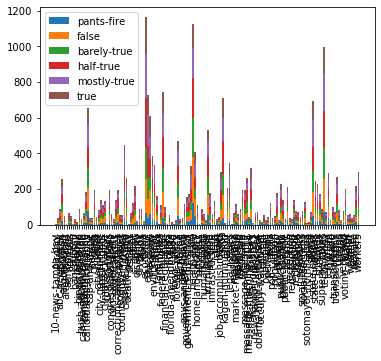

In [14]:
fig, ax = plt.subplots()
for i in range(len(label_types)):
#     counts = [x[i] for x in subject_dict.values()]
# #     print(counts)
#     ax.bar(subject_cols, counts)
    counts = [x[i] for x in subject_dict.values()]
#     print(counts)
    if i == 0:
        ax.bar(subject_cols, counts, label=label_types[i])
        sum_counts = counts
    else:
        ax.bar(subject_cols, counts, bottom=sum_counts, label=label_types[i])
        sum_counts = [i + j for i,j in zip(sum_counts, counts)]
plt.legend(label_types)
plt.xticks(rotation=90)
plt.show()

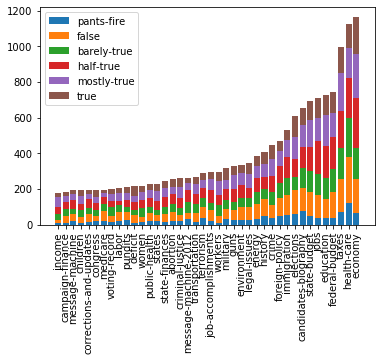

In [15]:
sorted_tuples = sorted(subject_dict.items(), key=lambda item: np.sum(item[1]))
k = 40
topk_subjects = sorted_tuples[-k:]
# print(topk_subjects)  # [(1, 1), (3, 4), (2, 9)]

topk_subject_names = [x[0] for x in topk_subjects]
fig, ax = plt.subplots()

for i in range(len(label_types)):
    counts = [x[1][i] for x in topk_subjects]
#     print(counts)
    if i == 0:
        ax.bar(topk_subject_names, counts, label=label_types[i])
        sum_counts = counts
    else:
        ax.bar(topk_subject_names, counts, bottom=sum_counts, label=label_types[i])
        sum_counts = [i + j for i,j in zip(sum_counts, counts)]
#     print(sum_counts)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [16]:
# analyze speakers
dummies = pd.get_dummies(train['speaker'], prefix='speaker')
train = pd.concat([train.drop(['speaker'], axis=1), dummies], axis=1)
speaker_columns = dummies.columns

In [17]:
# check relationships between speakers and labels
print(speaker_columns)
speaker_dict = {}
label_types = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
for lt in label_types:
    for s in speaker_columns:
#         temp = train.apply(lambda x : True 
#                             if x[s] == 1 and x['label'] == lt else False, axis = 1)
#         count = len(temp[temp == True].index)
#         print(count)
        count = train[(train[s] == 1) & (train['label'] == lt)].count()[0] # label is at 0th index
#         print(count)
#         print('s: {} lt: {}'.format(s, lt))
        if s in speaker_dict:
            speaker_dict[s].append(count)
        else:
            speaker_dict[s] = [count]
    print('finished: ', lt)

Index(['speaker_18-percent-american-public', 'speaker_60-plus-association',
       'speaker_AARP', 'speaker_Arizona-Citizens-Defense-League',
       'speaker_Ballesteros', 'speaker_Coast-Guard', 'speaker_GaGOP',
       'speaker_Kiplinger-com', 'speaker_Yes-on-79', 'speaker_abel-collins',
       ...
       'speaker_yes-84', 'speaker_yg-action-fund', 'speaker_yolanda-adrean',
       'speaker_young-americans-liberty', 'speaker_young-conservatives-texas',
       'speaker_yvette-mcgee-brown', 'speaker_zack-space',
       'speaker_zell-miller', 'speaker_zephyr-teachout',
       'speaker_zoe-lofgren'],
      dtype='object', length=2910)
finished:  pants-fire
finished:  false
finished:  barely-true
finished:  half-true
finished:  mostly-true
finished:  true


In [19]:
print(train['speaker_barack-obama'].value_counts())
print(train['speaker_donald-trump'].value_counts())

0    9750
1     488
Name: speaker_barack-obama, dtype: int64
0    9965
1     273
Name: speaker_donald-trump, dtype: int64


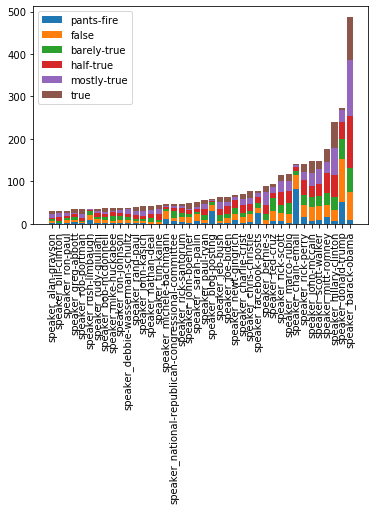

In [20]:
sorted_tuples = sorted(speaker_dict.items(), key=lambda item: np.sum(item[1]))
k = 40
topk_speakers = sorted_tuples[-k:]
# print(topk_speakers)  # [(1, 1), (3, 4), (2, 9)]

topk_speakers_names = [x[0] for x in topk_speakers]
fig, ax = plt.subplots()

for i in range(len(label_types)):
    counts = [x[1][i] for x in topk_speakers]
#     print(counts)
    if i == 0:
        ax.bar(topk_speakers_names, counts, label=label_types[i])
        sum_counts = counts
    else:
        ax.bar(topk_speakers_names, counts, bottom=sum_counts, label=label_types[i])
        sum_counts = [i + j for i,j in zip(sum_counts, counts)]
#     print(sum_counts)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [21]:
# party affiliation
dummies = pd.get_dummies(train['party_affiliation'], prefix='party_affiliation')
train = pd.concat([train.drop(['party_affiliation'], axis=1), dummies], axis=1)
party_affiliation_columns = dummies.columns

In [22]:
train.head()

,label,statement,speaker_job_title,state_info,barely_true,false,half_true,mostly_true,pants_on_fire,context,...,party_affiliation_liberal-party-canada,party_affiliation_libertarian,party_affiliation_newsmaker,party_affiliation_none,party_affiliation_ocean-state-tea-party-action,party_affiliation_organization,party_affiliation_republican,party_affiliation_state-official,party_affiliation_talk-show-host,party_affiliation_tea-party-member
0,false,Says the Annies List political group supports ...,State representative,Texas,0.0,1.0,0.0,0.0,0.0,a mailer,...,0,0,0,0,0,0,1,0,0,0
1,half-true,When did the decline of coal start? It started...,State delegate,Virginia,0.0,0.0,1.0,1.0,0.0,a floor speech.,...,0,0,0,0,0,0,0,0,0,0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",President,Illinois,70.0,71.0,160.0,163.0,9.0,Denver,...,0,0,0,0,0,0,0,0,0,0
3,false,Health care reform legislation is likely to ma...,NaN,NaN,7.0,19.0,3.0,5.0,44.0,a news release,...,0,0,0,1,0,0,0,0,0,0
4,half-true,The economic turnaround started at the end of ...,NaN,Florida,15.0,9.0,20.0,19.0,2.0,an interview on CNN,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# check relationships between party_affiliation and labels
print(party_affiliation_columns)
party_affiliation_dict = {}
label_types = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
for lt in label_types:
    for s in party_affiliation_columns:
#         temp = train.apply(lambda x : True 
#                             if x[s] == 1 and x['label'] == lt else False, axis = 1)
#         count = len(temp[temp == True].index)
#         print(count)
        count = train[(train[s] == 1) & (train['label'] == lt)].count()[0] # label is at 0th index
#         print(count)
#         print('s: {} lt: {}'.format(s, lt))
        if s in party_affiliation_dict:
            party_affiliation_dict[s].append(count)
        else:
            party_affiliation_dict[s] = [count]
    print('finished: ', lt)

Index(['party_affiliation_Moderate', 'party_affiliation_activist',
       'party_affiliation_business-leader', 'party_affiliation_columnist',
       'party_affiliation_constitution-party', 'party_affiliation_democrat',
       'party_affiliation_democratic-farmer-labor',
       'party_affiliation_education-official',
       'party_affiliation_government-body', 'party_affiliation_green',
       'party_affiliation_independent', 'party_affiliation_journalist',
       'party_affiliation_labor-leader',
       'party_affiliation_liberal-party-canada',
       'party_affiliation_libertarian', 'party_affiliation_newsmaker',
       'party_affiliation_none',
       'party_affiliation_ocean-state-tea-party-action',
       'party_affiliation_organization', 'party_affiliation_republican',
       'party_affiliation_state-official', 'party_affiliation_talk-show-host',
       'party_affiliation_tea-party-member'],
      dtype='object')
finished:  pants-fire
finished:  false
finished:  barely-true
finish

In [24]:
print(train['party_affiliation_republican'].value_counts())
print(train['party_affiliation_democrat'].value_counts())

0    5741
1    4497
Name: party_affiliation_republican, dtype: int64
0    6902
1    3336
Name: party_affiliation_democrat, dtype: int64


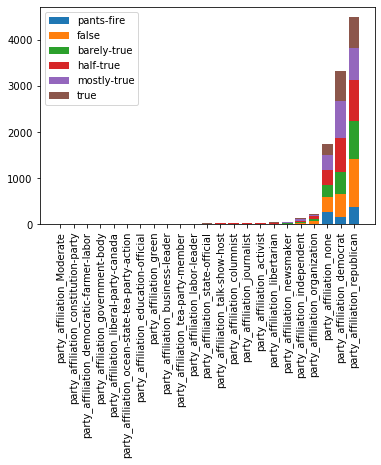

In [25]:
sorted_tuples = sorted(party_affiliation_dict.items(), key=lambda item: np.sum(item[1]))
k = 40
topk_party_affiliations = sorted_tuples[-k:]
# print(topk_party_affiliations)  # [(1, 1), (3, 4), (2, 9)]

topk_party_affiliations_names = [x[0] for x in topk_party_affiliations]
fig, ax = plt.subplots()

for i in range(len(label_types)):
    counts = [x[1][i] for x in topk_party_affiliations]
#     print(counts)
    if i == 0:
        ax.bar(topk_party_affiliations_names, counts, label=label_types[i])
        sum_counts = counts
    else:
        ax.bar(topk_party_affiliations_names, counts, bottom=sum_counts, label=label_types[i])
        sum_counts = [i + j for i,j in zip(sum_counts, counts)]
#     print(sum_counts)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [26]:
# speaker job title
dummies = pd.get_dummies(train['speaker_job_title'], prefix='speaker_job_title')
train = pd.concat([train.drop(['speaker_job_title'], axis=1), dummies], axis=1)
speaker_job_title_columns = dummies.columns

In [27]:
train.head()

,label,statement,state_info,barely_true,false,half_true,mostly_true,pants_on_fire,context,10-news-tampa-bay,...,speaker_job_title_transportation consultant,"speaker_job_title_transportation director, city of Roswell",speaker_job_title_venture capital company founder,speaker_job_title_venture capitalist,speaker_job_title_vice president of Phantom Fireworks,"speaker_job_title_vice president, Hilex Poly Co.","speaker_job_title_vice president, Rhode Island State Association of Firefighters",speaker_job_title_video,speaker_job_title_website,speaker_job_title_writer
0,false,Says the Annies List political group supports ...,Texas,0.0,1.0,0.0,0.0,0.0,a mailer,0,...,0,0,0,0,0,0,0,0,0,0
1,half-true,When did the decline of coal start? It started...,Virginia,0.0,0.0,1.0,1.0,0.0,a floor speech.,0,...,0,0,0,0,0,0,0,0,0,0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",Illinois,70.0,71.0,160.0,163.0,9.0,Denver,0,...,0,0,0,0,0,0,0,0,0,0
3,false,Health care reform legislation is likely to ma...,NaN,7.0,19.0,3.0,5.0,44.0,a news release,0,...,0,0,0,0,0,0,0,0,0,0
4,half-true,The economic turnaround started at the end of ...,Florida,15.0,9.0,20.0,19.0,2.0,an interview on CNN,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# check relationships between speaker job title and labels
print(speaker_job_title_columns)
speaker_job_title_dict = {}
label_types = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
for lt in label_types:
    for s in speaker_job_title_columns:
#         temp = train.apply(lambda x : True 
#                             if x[s] == 1 and x['label'] == lt else False, axis = 1)
#         count = len(temp[temp == True].index)
#         print(count)
        count = train[(train[s] == 1) & (train['label'] == lt)].count()[0] # label is at 0th index
#         print(count)
#         print('s: {} lt: {}'.format(s, lt))
        if s in speaker_job_title_dict:
            speaker_job_title_dict[s].append(count)
        else:
            speaker_job_title_dict[s] = [count]
    print('finished: ', lt)

Index(['speaker_job_title_ secretary-general of the United Nations',
       'speaker_job_title_4th Congressional District's congressman',
       'speaker_job_title_501 (c) (4) educational group',
       'speaker_job_title_8th District congressional candidate',
       'speaker_job_title_9-12 member in Tampa',
       'speaker_job_title_A liberal-oriented advocacy organization',
       'speaker_job_title_A ride-sharing service',
       'speaker_job_title_ABC News',
       'speaker_job_title_ABC News chief White House correspondent',
       'speaker_job_title_ABC News' Chief Health and Medical Editor. ',
       ...
       'speaker_job_title_transportation consultant',
       'speaker_job_title_transportation director, city of Roswell',
       'speaker_job_title_venture capital company founder',
       'speaker_job_title_venture capitalist',
       'speaker_job_title_vice president of Phantom Fireworks',
       'speaker_job_title_vice president, Hilex Poly Co.',
       'speaker_job_title_vi

In [42]:
print(train['speaker_job_title_President'].value_counts())
print(train['speaker_job_title_U.S. Senator'].value_counts())
print(train['speaker_job_title_None'].value_counts())

0    9746
1     492
Name: speaker_job_title_President, dtype: int64
0    9759
1     479
Name: speaker_job_title_U.S. Senator, dtype: int64
0    10237
1        1
Name: speaker_job_title_None, dtype: int64


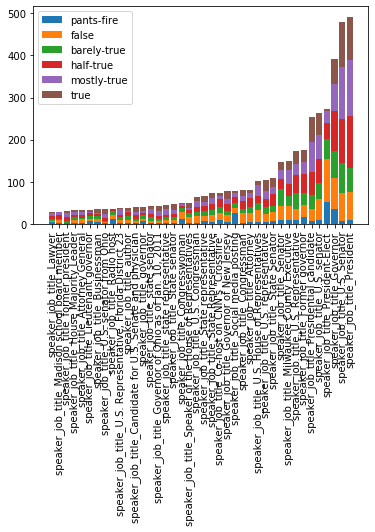

In [30]:
sorted_tuples = sorted(speaker_job_title_dict.items(), key=lambda item: np.sum(item[1]))
k = 40
topk_speaker_job_titles = sorted_tuples[-k:]
# print(topk_speaker_job_titles)  # [(1, 1), (3, 4), (2, 9)]

topk_speaker_job_titles_names = [x[0] for x in topk_speaker_job_titles]
fig, ax = plt.subplots()

for i in range(len(label_types)):
    counts = [x[1][i] for x in topk_speaker_job_titles]
#     print(counts)
    if i == 0:
        ax.bar(topk_speaker_job_titles_names, counts, label=label_types[i])
        sum_counts = counts
    else:
        ax.bar(topk_speaker_job_titles_names, counts, bottom=sum_counts, label=label_types[i])
        sum_counts = [i + j for i,j in zip(sum_counts, counts)]
#     print(sum_counts)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [31]:
# state info
dummies = pd.get_dummies(train['state_info'], prefix='state_info')
train = pd.concat([train.drop(['state_info'], axis=1), dummies], axis=1)
state_info_columns = dummies.columns

In [32]:
train.head()

,label,statement,barely_true,false,half_true,mostly_true,pants_on_fire,context,10-news-tampa-bay,Alcohol,...,state_info_Washington DC,state_info_Washington state,"state_info_Washington, D.C.","state_info_Washington, D.C.",state_info_West Virginia,state_info_Wisconsin,state_info_Wisconsin,state_info_Wyoming,state_info_ohio,state_info_the United States
0,false,Says the Annies List political group supports ...,0.0,1.0,0.0,0.0,0.0,a mailer,0,0,...,0,0,0,0,0,0,0,0,0,0
1,half-true,When did the decline of coal start? It started...,0.0,0.0,1.0,1.0,0.0,a floor speech.,0,0,...,0,0,0,0,0,0,0,0,0,0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",70.0,71.0,160.0,163.0,9.0,Denver,0,0,...,0,0,0,0,0,0,0,0,0,0
3,false,Health care reform legislation is likely to ma...,7.0,19.0,3.0,5.0,44.0,a news release,0,0,...,0,0,0,0,0,0,0,0,0,0
4,half-true,The economic turnaround started at the end of ...,15.0,9.0,20.0,19.0,2.0,an interview on CNN,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# check relationships between state info and labels
print(state_info_columns)
state_info_dict = {}
label_types = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
for lt in label_types:
    for s in state_info_columns:
#         temp = train.apply(lambda x : True 
#                             if x[s] == 1 and x['label'] == lt else False, axis = 1)
#         count = len(temp[temp == True].index)
#         print(count)
        # print(train[s])
        count = train[(train[s] == 1) & (train['label'] == lt)].count()[0] # label is at 0th index
#         print(count)
#         print('s: {} lt: {}'.format(s, lt))
        if s in state_info_dict:
            state_info_dict[s].append(count)
        else:
            state_info_dict[s] = [count]
    print('finished: ', lt)

Index(['state_info_Alabama', 'state_info_Alaska', 'state_info_Arizona',
       'state_info_Arkansas', 'state_info_Atlanta', 'state_info_California',
       'state_info_California ', 'state_info_China', 'state_info_Colorado',
       'state_info_Colorado ', 'state_info_Connecticut', 'state_info_Delaware',
       'state_info_District of Columbia', 'state_info_Florida',
       'state_info_Florida ', 'state_info_Georgia', 'state_info_Georgia ',
       'state_info_Hawaii', 'state_info_Idaho', 'state_info_Illinois',
       'state_info_Illinois ', 'state_info_Indiana', 'state_info_Iowa',
       'state_info_Kansas', 'state_info_Kentucky', 'state_info_Louisiana',
       'state_info_Maine', 'state_info_Maryland', 'state_info_Massachusetts',
       'state_info_Massachusetts ', 'state_info_Michigan',
       'state_info_Minnesota', 'state_info_Mississippi', 'state_info_Missouri',
       'state_info_Montana', 'state_info_Nebraska', 'state_info_Nevada',
       'state_info_New Hampshire', 'state_info_N

In [36]:
print(train['state_info_Texas'].value_counts())
print(train['state_info_Florida'].value_counts())

0    9229
1    1009
Name: state_info_Texas, dtype: int64
0    9241
1     997
Name: state_info_Florida, dtype: int64


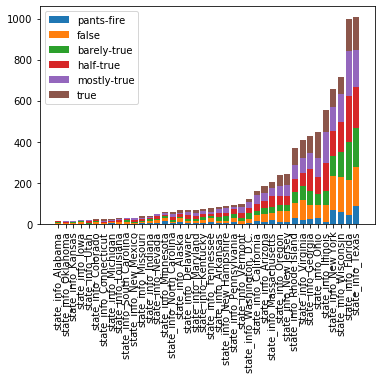

In [34]:
sorted_tuples = sorted(state_info_dict.items(), key=lambda item: np.sum(item[1]))
k = 40
topk_state_info = sorted_tuples[-k:]
# print(topk_state_info)  # [(1, 1), (3, 4), (2, 9)]

topk_state_info_names = [x[0] for x in topk_state_info]
fig, ax = plt.subplots()

for i in range(len(label_types)):
    counts = [x[1][i] for x in topk_state_info]
#     print(counts)
    if i == 0:
        ax.bar(topk_state_info_names, counts, label=label_types[i])
        sum_counts = counts
    else:
        ax.bar(topk_state_info_names, counts, bottom=sum_counts, label=label_types[i])
        sum_counts = [i + j for i,j in zip(sum_counts, counts)]
#     print(sum_counts)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [38]:
# context
print(train['context'].unique())
print(len(train['context'].unique()))

['a mailer' 'a floor speech.' 'Denver' ...
 'a recorded telephone message to Cranston residents'
 'interview on "The Colbert Report"'
 "a televised debate on Miami's WPLG-10 against Kendrick Meek."]
4346
